# 🧭 QAOA para o Problema do Caixeiro Viajante (TSP)

Este notebook implementa o TSP usando QAOA seguindo a formulação matemática:

1. **Variáveis de decisão**: $x_{i,t} \in \{0,1\}$
2. **Formulação QUBO**: $H_{QUBO} = H_{dist} + H_{p1} + H_{p2}$
3. **Mapeamento quântico**: $x_{i,t} \rightarrow \frac{I - \hat{Z}_{i,t}}{2}$
4. **QAOA**: Operadores $U_C(\gamma)$ e $U_M(\beta)$

---
## 📦 Importar Bibliotecas

In [1]:
# Importar bibliotecas importantes
from qiskit import QuantumCircuit
import numpy as np
from qiskit_aer import AerSimulator
from qiskit import transpile
from scipy.optimize import minimize
from itertools import permutations
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

# Simulador
sim = AerSimulator()

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


---
## 📊 Definição dos Parâmetros do Problema

### Matriz de Distâncias $D$

A matriz $D$ contém as distâncias $d_{ij}$ entre cada par de cidades.

### Variáveis de Decisão $x_{i,t}$

$$x_{i,t} = \begin{cases} 1 & \text{se a cidade } i \text{ é visitada no passo } t \\ 0 & \text{caso contrário} \end{cases}$$

Para $n$ cidades, temos $n^2$ variáveis binárias, ou seja, **$n^2$ qubits**.

In [2]:
# Matrizes de distâncias para 3 a 6 cidades
graphs = {
    3: np.array([
        [0, 10, 15],
        [10, 0, 20],
        [15, 20, 0]
    ], dtype=float),
    
    4: np.array([
        [0, 1, 50, 50],
        [1, 0, 2, 50],
        [50, 2, 0, 3],
        [50, 50, 3, 0]
    ], dtype=float),
    
    5: np.array([
        [0, 2, 9, 10, 7],
        [1, 0, 6, 4, 3],
        [15, 7, 0, 8, 3],
        [6, 3, 12, 0, 11],
        [9, 7, 5, 6, 0]
    ], dtype=float),
    
   
}

# Exibir matrizes
for n, D in graphs.items():
    print(f"\n📍 Matriz D ({n} cidades) - {n**2} qubits:")
    print(D.astype(int))


📍 Matriz D (3 cidades) - 9 qubits:
[[ 0 10 15]
 [10  0 20]
 [15 20  0]]

📍 Matriz D (4 cidades) - 16 qubits:
[[ 0  1 50 50]
 [ 1  0  2 50]
 [50  2  0  3]
 [50 50  3  0]]

📍 Matriz D (5 cidades) - 25 qubits:
[[ 0  2  9 10  7]
 [ 1  0  6  4  3]
 [15  7  0  8  3]
 [ 6  3 12  0 11]
 [ 9  7  5  6  0]]


In [3]:
# Mapeamento (cidade, tempo) → índice do qubit
# x_{i,t} corresponde ao qubit de índice (i * n + t)

def qubit_index(cidade, tempo, n):
    """
    Mapeia a variável x_{i,t} para o índice do qubit.
    
    Seguindo a notação do texto teórico:
    x_{i,t} → qubit[i * n + t]
    """
    return cidade * n + tempo


# Visualização do mapeamento para n=3
print("🔢 Mapeamento de variáveis x_{i,t} para qubits (n=3):")
print("="*50)
print(f"{'Variável':<12} {'Qubit':<8} {'Significado'}")
print("-"*50)
for i in range(3):
    for t in range(3):
        q = qubit_index(i, t, 3)
        print(f"x_{{{i},{t}}}        q[{q}]     Cidade {i} no tempo {t}")

🔢 Mapeamento de variáveis x_{i,t} para qubits (n=3):
Variável     Qubit    Significado
--------------------------------------------------
x_{0,0}        q[0]     Cidade 0 no tempo 0
x_{0,1}        q[1]     Cidade 0 no tempo 1
x_{0,2}        q[2]     Cidade 0 no tempo 2
x_{1,0}        q[3]     Cidade 1 no tempo 0
x_{1,1}        q[4]     Cidade 1 no tempo 1
x_{1,2}        q[5]     Cidade 1 no tempo 2
x_{2,0}        q[6]     Cidade 2 no tempo 0
x_{2,1}        q[7]     Cidade 2 no tempo 1
x_{2,2}        q[8]     Cidade 2 no tempo 2


---
## 📐 Construção do Hamiltoniano de Custo

### Formulação QUBO

O Hamiltoniano QUBO combina o custo das distâncias com as penalidades:

$$H_{QUBO} = \underbrace{\sum_{i,j=0}^{n-1} \sum_{t=0}^{n-1} d_{ij} \, x_{i,t} \, x_{j,(t+1) \mod n}}_{H_{dist}} + \underbrace{A \sum_{i=0}^{n-1} \left( \sum_{t=0}^{n-1} x_{i,t} - 1 \right)^2}_{H_{p1}} + \underbrace{A \sum_{t=0}^{n-1} \left( \sum_{i=0}^{n-1} x_{i,t} - 1 \right)^2}_{H_{p2}}$$

Onde:
- $H_{dist}$: Custo total da rota
- $H_{p1}$: Penalidade - cada cidade visitada exatamente uma vez
- $H_{p2}$: Penalidade - cada tempo tem exatamente uma cidade
- $A$: Fator de penalidade (deve ser $> \max(d_{ij}) \cdot n$)

### Mapeamento para Operadores de Pauli

$$x_{i,t} \longrightarrow \hat{n}_{i,t} = \frac{I - \hat{Z}_{i,t}}{2}$$

Isso resulta em termos $Z_i$ (campo local) e $Z_i Z_j$ (interação).

In [4]:
def construir_hamiltoniano_tsp(D, penalty_multiplier=2.0):
    """
    Constrói os coeficientes do Hamiltoniano de custo para o TSP.
    
    Seguindo a formulação teórica, o Hamiltoniano quântico é:
    Ĥ_C = Σ h_i Z_i + Σ J_ij Z_i Z_j
    
    Derivado de H_QUBO usando a substituição x = (1-Z)/2
    
    Parâmetros:
    -----------
    D : np.array
        Matriz de distâncias
    penalty_multiplier : float
        Multiplicador para o fator de penalidade A
        (valores maiores forçam mais soluções válidas)
    
    Retorna:
    --------
    h : dict - Coeficientes dos termos Z_i (campo local)
    J : dict - Coeficientes dos termos Z_i Z_j (interação)
    A : float - Fator de penalidade usado
    """
    n = len(D)
    
    # Fator de penalidade A (aumentado para melhorar soluções válidas)
    A = penalty_multiplier * np.max(D) * n
    
    h = {}  # Termos Z_i
    J = {}  # Termos Z_i Z_j
    
    # Inicializa coeficientes
    for q in range(n * n):
        h[q] = 0.0
    
    # =========================================
    # H_dist: Termo de distância
    # Σ_{i,j,t} d_ij * x_{i,t} * x_{j,(t+1) mod n}
    # =========================================
    for i in range(n):
        for j in range(n):
            if i != j:
                d_ij = D[i, j]
                for t in range(n):
                    t_next = (t + 1) % n
                    q_a = qubit_index(i, t, n)
                    q_b = qubit_index(j, t_next, n)
                    
                    h[q_a] -= d_ij / 4
                    h[q_b] -= d_ij / 4
                    
                    key = (min(q_a, q_b), max(q_a, q_b))
                    J[key] = J.get(key, 0) + d_ij / 4
    
    # =========================================
    # H_p1: Cada cidade visitada exatamente uma vez
    # A * Σ_i (Σ_t x_{i,t} - 1)²
    # =========================================
    for i in range(n):
        for t in range(n):
            q = qubit_index(i, t, n)
            h[q] += A / 2
            
            for t2 in range(t + 1, n):
                q2 = qubit_index(i, t2, n)
                h[q] -= A / 2
                h[q2] -= A / 2
                key = (min(q, q2), max(q, q2))
                J[key] = J.get(key, 0) + A / 2
    
    # =========================================
    # H_p2: Cada tempo tem exatamente uma cidade
    # A * Σ_t (Σ_i x_{i,t} - 1)²
    # =========================================
    for t in range(n):
        for i in range(n):
            q = qubit_index(i, t, n)
            h[q] += A / 2
            
            for i2 in range(i + 1, n):
                q2 = qubit_index(i2, t, n)
                h[q] -= A / 2
                h[q2] -= A / 2
                key = (min(q, q2), max(q, q2))
                J[key] = J.get(key, 0) + A / 2
    
    return h, J, A


# Demonstração para n=3
h_demo, J_demo, A_demo = construir_hamiltoniano_tsp(graphs[3])
print(f"\n📐 Hamiltoniano de Custo Ĥ_C para n=3:")
print(f"   Fator de penalidade A = {A_demo}")
print(f"   Termos Z_i (campo local): {len([v for v in h_demo.values() if abs(v) > 1e-10])}")
print(f"   Termos Z_i Z_j (interação): {len(J_demo)}")


📐 Hamiltoniano de Custo Ĥ_C para n=3:
   Fator de penalidade A = 120.0
   Termos Z_i (campo local): 9
   Termos Z_i Z_j (interação): 36


---
## 🔄 Camada (Layer) do QAOA

### Estrutura do Circuito QAOA

Cada camada do QAOA consiste em dois operadores:

**1. Operador de Custo (Phase Operator):**
$$U_C(\gamma) = e^{-i \gamma \hat{H}_C}$$

**2. Operador de Mistura (Mixer):**
$$U_M(\beta) = e^{-i \beta \hat{H}_M}, \quad \text{com} \quad \hat{H}_M = \sum_{k=1}^{n^2} \hat{X}_k$$

### Implementação no Circuito

- Termo $e^{-i\gamma h_k Z_k}$ → Porta **RZ(2γh_k)** no qubit k
- Termo $e^{-i\gamma J_{ij} Z_i Z_j}$ → **CNOT(i,j) · RZ(2γJ_ij) · CNOT(i,j)**
- Termo $e^{-i\beta X_k}$ → Porta **RX(2β)** no qubit k

In [5]:
def qaoa_layer(qc, h, J, gamma, beta):
    """
    Implementa uma camada do QAOA para o TSP.
    
    Conforme o texto teórico:
    U_C(γ) = exp(-iγ Ĥ_C) onde Ĥ_C = Σ h_i Z_i + Σ J_ij Z_i Z_j
    U_M(β) = exp(-iβ Ĥ_M) onde Ĥ_M = Σ X_k
    
    Parâmetros:
    -----------
    qc : QuantumCircuit
        Circuito quântico
    h : dict
        Coeficientes dos termos Z_i
    J : dict
        Coeficientes dos termos Z_i Z_j
    gamma : float
        Parâmetro γ do operador de custo
    beta : float
        Parâmetro β do operador mixer
    """
    # =========================================
    # OPERADOR DE CUSTO U_C(γ)
    # =========================================
    
    # Termos Z_i: exp(-iγ h_i Z_i) = RZ(2γ h_i)
    for qubit, coef in h.items():
        if abs(coef) > 1e-10:
            qc.rz(2 * gamma * coef, qubit)
    
    # Termos Z_i Z_j: exp(-iγ J_ij Z_i Z_j)
    # Implementação: CNOT(i,j) · RZ(2γJ_ij,j) · CNOT(i,j)
    for (q_i, q_j), coef in J.items():
        if abs(coef) > 1e-10:
            qc.cx(q_i, q_j)
            qc.rz(2 * gamma * coef, q_j)
            qc.cx(q_i, q_j)
    
    # =========================================
    # OPERADOR MIXER U_M(β)
    # Ĥ_M = Σ X_k
    # =========================================
    for q in range(qc.num_qubits):
        qc.rx(2 * beta, q)

---
## 🔌 Circuito Completo do QAOA

O circuito QAOA completo é construído:

1. **Estado inicial**: Superposição uniforme $|s\rangle = |+\rangle^{\otimes n^2}$
2. **Camadas QAOA**: Aplicação alternada de $U_C(\gamma_l)$ e $U_M(\beta_l)$ para $l = 1, ..., p$

$$|\psi(\vec{\gamma}, \vec{\beta})\rangle = \prod_{l=1}^{p} U_M(\beta_l) U_C(\gamma_l) |+\rangle^{\otimes n^2}$$

In [6]:
def qaoa_circuit(h, J, num_qubits, gammas, betas):
    """
    Constrói o circuito completo do QAOA para o TSP.
    
    Conforme o texto teórico:
    |ψ(γ,β)⟩ = Π_{l=1}^{p} U_M(β_l) U_C(γ_l) |+⟩^{⊗n²}
    
    Parâmetros:
    -----------
    h : dict - Coeficientes Z_i do Hamiltoniano
    J : dict - Coeficientes Z_i Z_j do Hamiltoniano
    num_qubits : int - Número de qubits (n²)
    gammas : list - Parâmetros γ para cada camada
    betas : list - Parâmetros β para cada camada
    
    Retorna:
    --------
    qc : QuantumCircuit - Circuito QAOA completo
    """
    qc = QuantumCircuit(num_qubits)
    
    # Estado inicial: |+⟩^{⊗n²}
    qc.h(range(num_qubits))
    
    # Camadas QAOA (p camadas)
    for gamma, beta in zip(gammas, betas):
        qaoa_layer(qc, h, J, gamma, beta)
    
    return qc

📊 Circuito QAOA para TSP (n=3, p=1):
   Qubits: 9
   Profundidade: 39
   Portas: {'cx': 72, 'rz': 45, 'h': 9, 'rx': 9}


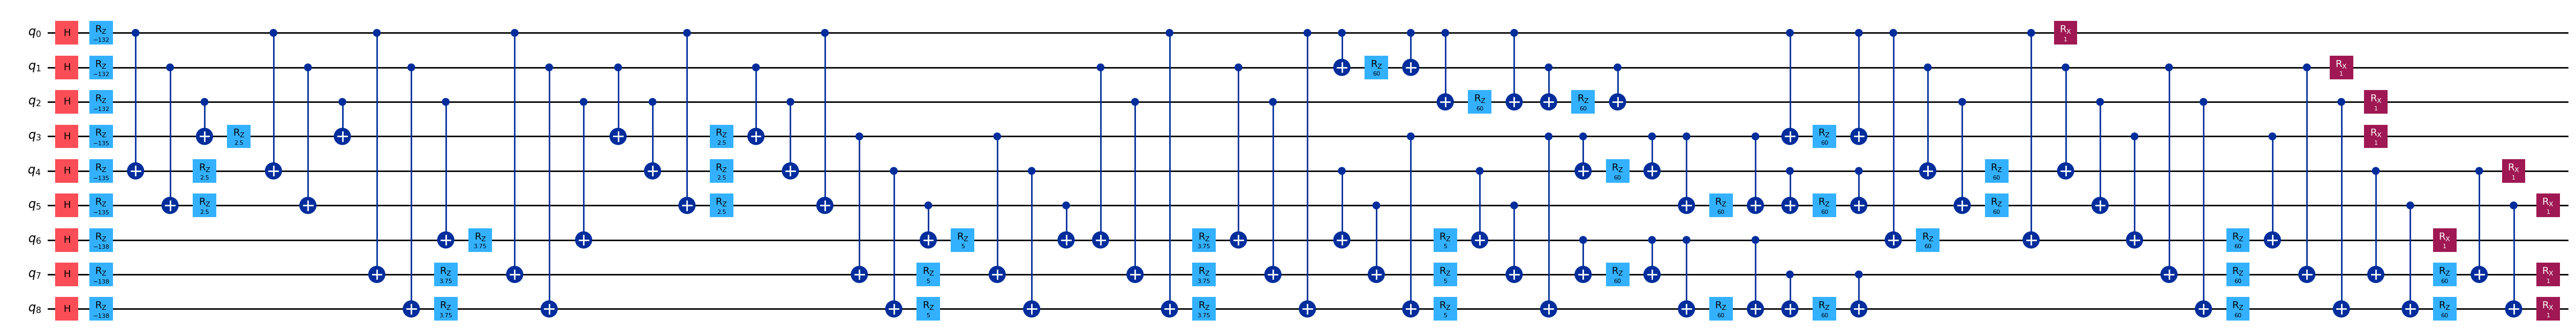

In [7]:
# Visualizar circuito QAOA para n=3, p=1 camada
h_demo, J_demo, _ = construir_hamiltoniano_tsp(graphs[3])
qc_exemplo = qaoa_circuit(h_demo, J_demo, 9, gammas=[0.5], betas=[0.5])

print(f"📊 Circuito QAOA para TSP (n=3, p=1):")
print(f"   Qubits: {qc_exemplo.num_qubits}")
print(f"   Profundidade: {qc_exemplo.depth()}")
print(f"   Portas: {dict(qc_exemplo.count_ops())}")

# Desenhar circuito
qc_exemplo.draw('mpl', fold=80)

---
## 💰 Função Custo do TSP

### Soluções Válidas vs Inválidas

Uma bitstring de $n^2$ bits codifica a matriz $x_{i,t}$. Para ser **válida**, deve satisfazer:

1. **Restrição 1**: $\sum_{t=0}^{n-1} x_{i,t} = 1$ para todo $i$ (cada cidade visitada uma vez)
2. **Restrição 2**: $\sum_{i=0}^{n-1} x_{i,t} = 1$ para todo $t$ (cada tempo tem uma cidade)

**Importante**: A maioria das bitstrings viola as restrições!
- n=3: apenas 6 de 512 (1.2%) são válidas
- n=4: apenas 24 de 65.536 (0.04%) são válidas
- n=5: apenas 120 de 33.554.432 (0.0004%) são válidas

In [8]:
def decodificar_bitstring(bitstring, n):
    """
    Decodifica uma bitstring em uma rota TSP.
    
    Verifica as restrições do texto teórico:
    1. Σ_t x_{i,t} = 1 para todo i (cada cidade visitada uma vez)
    2. Σ_i x_{i,t} = 1 para todo t (cada tempo tem uma cidade)
    
    Retorna:
    --------
    rota : tuple ou None - Sequência de cidades ou None se inválida
    valida : bool - True se satisfaz as restrições
    """
    # Reconstrói matriz x[cidade][tempo]
    x = np.zeros((n, n), dtype=int)
    for idx, bit in enumerate(bitstring):
        cidade = idx // n
        tempo = idx % n
        x[cidade, tempo] = int(bit)
    
    # Verifica restrição 1: Σ_t x_{i,t} = 1
    for i in range(n):
        if np.sum(x[i, :]) != 1:
            return None, False
    
    # Verifica restrição 2: Σ_i x_{i,t} = 1
    for t in range(n):
        if np.sum(x[:, t]) != 1:
            return None, False
    
    # Extrai rota
    rota = []
    for t in range(n):
        for i in range(n):
            if x[i, t] == 1:
                rota.append(i)
                break
    
    rota.append(rota[0])  # Fecha o ciclo
    return tuple(rota), True


def tsp_cost(bitstring, D):
    """
    Calcula o custo de uma solução TSP.
    
    Implementa a função objetivo do texto teórico:
    C(x) = Σ_{i,j,t} d_ij * x_{i,t} * x_{j,(t+1) mod n}
    
    Retorna:
    --------
    custo : float - Custo da rota (ou infinito se inválida)
    rota : tuple ou None - Rota decodificada
    valida : bool - Se a solução é válida
    """
    n = len(D)
    rota, valida = decodificar_bitstring(bitstring, n)
    
    if not valida:
        return float('inf'), None, False
    
    # Calcula custo da rota
    custo = 0
    for t in range(n):
        i = rota[t]
        j = rota[t + 1]
        custo += D[i, j]
    
    return custo, rota, True


def expected_cost(counts, D):
    """
    Calcula o valor esperado da função custo TSP.
    
    ⟨Ĥ_C⟩ = Σ_x P(x) * C(x)
    
    Retorna:
    --------
    exp_cost : float - Valor esperado do custo
    frac_validas : float - Fração de soluções válidas
    melhor : tuple - (melhor_rota, melhor_custo)
    """
    n = len(D)
    shots = sum(counts.values())
    penalidade = np.max(D) * n * 10
    
    exp_cost = 0
    n_validas = 0
    melhor_custo = float('inf')
    melhor_rota = None
    
    for bitstring, count in counts.items():
        bs = bitstring[::-1]  # Qiskit usa ordem invertida
        custo, rota, valida = tsp_cost(bs, D)
        
        if valida:
            n_validas += count
            exp_cost += count * custo
            if custo < melhor_custo:
                melhor_custo = custo
                melhor_rota = rota
        else:
            exp_cost += count * penalidade
    
    return exp_cost / shots, n_validas / shots, (melhor_rota, melhor_custo)

---
## 🎯 Ciclo Híbrido: Função Objetivo e Otimização

O QAOA opera em um **ciclo híbrido clássico-quântico**:

1. **Quântico**: Prepara $|\psi(\gamma, \beta)\rangle$ e mede
2. **Clássico**: Calcula $\langle \psi | \hat{H}_C | \psi \rangle$ e ajusta parâmetros

O otimizador **COBYLA** minimiza o valor esperado para encontrar os parâmetros ótimos.

In [9]:
def objective(params, h, J, D, num_qubits, p, shots):
    """
    Função objetivo para minimização do QAOA (ciclo híbrido).
    
    Esta função:
    1. Recebe os parâmetros γ e β
    2. Constrói o circuito QAOA (QUÂNTICO)
    3. Executa medições no simulador (QUÂNTICO)
    4. Calcula o valor esperado ⟨Ĥ_C⟩ (CLÁSSICO)
    
    Parâmetros:
    -----------
    params : array - [γ_1, ..., γ_p, β_1, ..., β_p]
    h, J : dicts - Coeficientes do Hamiltoniano
    D : np.array - Matriz de distâncias
    num_qubits : int - Número de qubits
    p : int - Número de camadas
    shots : int - Número de medições
    """
    gammas = params[:p]
    betas = params[p:]
    
    # Constrói circuito
    qc = qaoa_circuit(h, J, num_qubits, gammas, betas)
    qc.measure_all()
    
    # Transpila e executa
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts()
    
    # Calcula valor esperado
    exp_cost, _, _ = expected_cost(counts, D)
    
    return exp_cost

In [10]:
def brute_force_tsp(D):
    """
    Resolve TSP por força bruta (solução ótima garantida).
    Complexidade: O(n!)
    """
    n = len(D)
    melhor_rota = None
    melhor_custo = float('inf')
    
    for perm in permutations(range(1, n)):
        rota = (0,) + perm + (0,)
        custo = sum(D[rota[i], rota[i+1]] for i in range(n))
        if custo < melhor_custo:
            melhor_custo = custo
            melhor_rota = rota
    
    return melhor_rota, melhor_custo

---
## 🚀 Execução e Comparação: Brute Force vs QAOA

### Parâmetros Otimizados

Para melhorar a taxa de **soluções válidas**:
- `penalty_multiplier = 2.0`: Penalidade mais forte
- `p = 3`: Mais camadas para maior expressividade
- `shots = 8192`: Mais medições para melhor estatística
- `maxiter = 300`: Mais iterações para convergência

In [11]:
# =============================================================================
# PARÂMETROS DO EXPERIMENTO
# =============================================================================

PARAMS = {
    'penalty_multiplier': 2.0,  # Multiplicador da penalidade A
    'p': 3,                     # Número de camadas QAOA
    'shots': 8192,              # Número de medições
    'maxiter': 300,             # Iterações máximas do otimizador
}

print("⚙️  Parâmetros do Experimento:")
for k, v in PARAMS.items():
    print(f"   {k}: {v}")

⚙️  Parâmetros do Experimento:
   penalty_multiplier: 2.0
   p: 3
   shots: 8192
   maxiter: 300


In [12]:
def executar_comparacao(graphs, params):
    """
    Executa comparação sistemática entre Brute Force e QAOA.
    
    Retorna DataFrame com métricas:
    - Número de cidades e qubits
    - Tempo clássico vs quântico
    - Custo ótimo vs QAOA
    - Gap relativo ao ótimo
    - Porcentagem de soluções válidas
    """
    resultados = []
    
    for n_cidades, D in graphs.items():
        print(f"\n{'='*70}")
        print(f"📍 PROCESSANDO: {n_cidades} CIDADES ({n_cidades**2} qubits)")
        print(f"{'='*70}")
        
        n = len(D)
        num_qubits = n ** 2
        
        # =============================================================
        # BRUTE FORCE CLÁSSICO
        # =============================================================
        print(f"\n[1/2] 🔍 Executando Brute Force Clássico...")
        
        inicio_bf = time.time()
        rota_bf, custo_bf = brute_force_tsp(D)
        tempo_bf = time.time() - inicio_bf
        
        print(f"      ✅ Rota ótima: {rota_bf}")
        print(f"      ✅ Custo: {custo_bf}")
        print(f"      ✅ Tempo: {tempo_bf:.6f}s")
        
        # =============================================================
        # QAOA
        # =============================================================
        print(f"\n[2/2] ⚛️  Executando QAOA (p={params['p']})...")
        
        # Construir Hamiltoniano
        h, J, A = construir_hamiltoniano_tsp(D, params['penalty_multiplier'])
        print(f"      Penalidade A = {A:.2f}")
        
        inicio_qaoa = time.time()
        
        # Otimização com COBYLA
        init_params = np.random.uniform(0, np.pi, 2 * params['p'])
        
        res = minimize(
            objective,
            init_params,
            args=(h, J, D, num_qubits, params['p'], params['shots']),
            method="COBYLA",
            options={'maxiter': params['maxiter']}
        )
        
        # Circuito final otimizado
        gammas = res.x[:params['p']]
        betas = res.x[params['p']:]
        qc_final = qaoa_circuit(h, J, num_qubits, gammas, betas)
        qc_final.measure_all()
        
        # Execução final com mais shots
        tqc = transpile(qc_final, sim)
        result = sim.run(tqc, shots=params['shots']).result()
        counts = result.get_counts()
        
        tempo_qaoa = time.time() - inicio_qaoa
        
        # Extrair resultados
        _, frac_validas, (melhor_rota_qaoa, melhor_custo_qaoa) = expected_cost(counts, D)
        
        # Tratar caso sem solução válida
        if melhor_rota_qaoa is None:
            melhor_custo_qaoa = float('inf')
            gap_relativo = float('inf')
            melhor_rota_qaoa = "N/A"
        else:
            gap_relativo = ((melhor_custo_qaoa - custo_bf) / custo_bf) * 100
        
        print(f"      ✅ Melhor rota: {melhor_rota_qaoa}")
        print(f"      ✅ Custo QAOA: {melhor_custo_qaoa}")
        print(f"      ✅ Tempo: {tempo_qaoa:.2f}s")
        print(f"      ✅ Soluções válidas: {100*frac_validas:.2f}%")
        print(f"      ✅ Gap relativo: {gap_relativo:.2f}%")
        
        # Armazenar resultado
        resultados.append({
            'Cidades (n)': n_cidades,
            'Qubits (n²)': num_qubits,
            'Rota Clássica': str(rota_bf),
            'Custo Clássico': custo_bf,
            'Tempo Clássico (s)': tempo_bf,
            'Rota QAOA': str(melhor_rota_qaoa),
            'Custo QAOA': melhor_custo_qaoa if melhor_custo_qaoa != float('inf') else 'N/A',
            'Tempo QAOA (s)': tempo_qaoa,
            'Gap Relativo (%)': gap_relativo if gap_relativo != float('inf') else 'N/A',
            'Soluções Válidas (%)': frac_validas * 100,
            'Ótimo Encontrado': 'Sim' if melhor_custo_qaoa == custo_bf else 'Não'
        })
    
    return pd.DataFrame(resultados)

In [13]:
# =============================================================================
# EXECUTAR COMPARAÇÃO
# =============================================================================

print("=" * 70)
print("🚀 COMPARAÇÃO SISTEMÁTICA: BRUTE FORCE vs QAOA")
print("=" * 70)

df_resultados = executar_comparacao(graphs, PARAMS)

print(f"\n{'='*70}")
print("✅ PROCESSAMENTO CONCLUÍDO!")
print("=" * 70)

🚀 COMPARAÇÃO SISTEMÁTICA: BRUTE FORCE vs QAOA

📍 PROCESSANDO: 3 CIDADES (9 qubits)

[1/2] 🔍 Executando Brute Force Clássico...
      ✅ Rota ótima: (0, 1, 2, 0)
      ✅ Custo: 45.0
      ✅ Tempo: 0.000016s

[2/2] ⚛️  Executando QAOA (p=3)...
      Penalidade A = 120.00
      ✅ Melhor rota: (2, 1, 0, 2)
      ✅ Custo QAOA: 45.0
      ✅ Tempo: 11.84s
      ✅ Soluções válidas: 25.92%
      ✅ Gap relativo: 0.00%

📍 PROCESSANDO: 4 CIDADES (16 qubits)

[1/2] 🔍 Executando Brute Force Clássico...
      ✅ Rota ótima: (0, 1, 2, 3, 0)
      ✅ Custo: 56.0
      ✅ Tempo: 0.000024s

[2/2] ⚛️  Executando QAOA (p=3)...
      Penalidade A = 400.00
      ✅ Melhor rota: (2, 0, 1, 3, 2)
      ✅ Custo QAOA: 104.0
      ✅ Tempo: 15.23s
      ✅ Soluções válidas: 0.05%
      ✅ Gap relativo: 85.71%

📍 PROCESSANDO: 5 CIDADES (25 qubits)

[1/2] 🔍 Executando Brute Force Clássico...
      ✅ Rota ótima: (0, 2, 4, 3, 1, 0)
      ✅ Custo: 22.0
      ✅ Tempo: 0.000045s

[2/2] ⚛️  Executando QAOA (p=3)...
      Penalida

---
## 📊 Resultados e Análise

In [ ]:
# =============================================================================
# TABELA COMPLETA DE RESULTADOS
# =============================================================================

print("\n" + "=" * 70)
print("📊 TABELA COMPLETA DE RESULTADOS")
print("=" * 70 + "\n")

display(df_resultados)

In [ ]:
# =============================================================================
# TABELA RESUMIDA (conforme enunciado)
# =============================================================================

print("\n" + "=" * 70)
print("📋 RESUMO: TEMPO, CUSTO E DISTÂNCIA RELATIVA AO ÓTIMO")
print("=" * 70 + "\n")

df_resumo = df_resultados[[
    'Cidades (n)', 
    'Tempo Clássico (s)', 
    'Tempo QAOA (s)',
    'Custo Clássico', 
    'Custo QAOA', 
    'Gap Relativo (%)',
    'Soluções Válidas (%)'
]].copy()

df_resumo.columns = [
    'Cidades',
    'Tempo Clássico (s)',
    'Tempo Quântico (s)',
    'Custo Ótimo',
    'Custo QAOA',
    'Distância Relativa (%)',
    'Soluções Válidas (%)'
]

display(df_resumo)

In [ ]:
# =============================================================================
# GRÁFICOS DE ANÁLISE
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Preparar dados
x = df_resultados['Cidades (n)'].values
width = 0.35

# Gráfico 1: Comparação de Tempos
ax1 = axes[0, 0]
ax1.bar(x - width/2, df_resultados['Tempo Clássico (s)'], width, 
        label='Brute Force', color='steelblue')
ax1.bar(x + width/2, df_resultados['Tempo QAOA (s)'], width, 
        label='QAOA', color='purple', alpha=0.8)
ax1.set_xlabel('Número de Cidades')
ax1.set_ylabel('Tempo (s)')
ax1.set_title('Tempo de Execução: Clássico vs QAOA')
ax1.legend()
ax1.set_xticks(x)
ax1.set_yscale('log')

# Gráfico 2: Comparação de Custos
ax2 = axes[0, 1]
custos_qaoa = [c if c != 'N/A' else 0 for c in df_resultados['Custo QAOA']]
ax2.bar(x - width/2, df_resultados['Custo Clássico'], width, 
        label='Ótimo (BF)', color='steelblue')
ax2.bar(x + width/2, custos_qaoa, width, 
        label='QAOA', color='purple', alpha=0.8)
ax2.set_xlabel('Número de Cidades')
ax2.set_ylabel('Custo da Rota')
ax2.set_title('Custo da Rota: Ótimo vs QAOA')
ax2.legend()
ax2.set_xticks(x)

# Gráfico 3: Gap Relativo
ax3 = axes[1, 0]
gaps = [g if g != 'N/A' and g != float('inf') else 100 for g in df_resultados['Gap Relativo (%)']]
colors = ['green' if g == 0 else 'orange' if g < 50 else 'red' for g in gaps]
ax3.bar(x, gaps, color=colors)
ax3.set_xlabel('Número de Cidades')
ax3.set_ylabel('Gap Relativo (%)')
ax3.set_title('Distância Relativa ao Ótimo\n(Verde=Ótimo, Laranja<50%, Vermelho≥50%)')
ax3.axhline(y=0, color='green', linestyle='--', alpha=0.5)
ax3.set_xticks(x)

# Gráfico 4: Soluções Válidas
ax4 = axes[1, 1]
ax4.bar(x, df_resultados['Soluções Válidas (%)'], color='teal')
ax4.set_xlabel('Número de Cidades')
ax4.set_ylabel('Soluções Válidas (%)')
ax4.set_title('Porcentagem de Soluções Válidas (QAOA)')
ax4.set_xticks(x)
ax4.set_ylim(0, max(df_resultados['Soluções Válidas (%)']) * 1.2 + 1)

plt.tight_layout()
plt.savefig('comparacao_bf_qaoa.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📁 Gráfico salvo como 'comparacao_bf_qaoa.png'")

In [ ]:
# =============================================================================
# ANÁLISE DE DESEMPENHO E LIMITAÇÕES
# =============================================================================

print("\n" + "=" * 70)
print("📈 ANÁLISE DE DESEMPENHO E LIMITAÇÕES")
print("=" * 70)

print("\n🔹 DESEMPENHO DO BRUTE FORCE (Clássico):")
print("-" * 50)
print("   • Sempre encontra a solução ÓTIMA (garantido)")
print("   • Complexidade: O(n!) - cresce fatorialmente")
print(f"   • Tempo para n=3: {df_resultados[df_resultados['Cidades (n)']==3]['Tempo Clássico (s)'].values[0]:.6f}s")
print(f"   • Tempo para n=6: {df_resultados[df_resultados['Cidades (n)']==6]['Tempo Clássico (s)'].values[0]:.6f}s")
print("   • Limitação: Inviável para n > 12-15 cidades")

print("\n🔹 DESEMPENHO DO QAOA (Quântico simulado):")
print("-" * 50)
n_otimos = df_resultados[df_resultados['Ótimo Encontrado'] == 'Sim'].shape[0]
print(f"   • Soluções ótimas encontradas: {n_otimos}/{len(graphs)}")

gaps_validos = [g for g in df_resultados['Gap Relativo (%)'] if g != 'N/A' and g != float('inf')]
if gaps_validos:
    print(f"   • Gap médio (quando encontra solução): {np.mean(gaps_validos):.2f}%")

print(f"   • Média de soluções válidas: {df_resultados['Soluções Válidas (%)'].mean():.2f}%")
print(f"   • Camadas utilizadas (p): {PARAMS['p']}")
print(f"   • Shots por execução: {PARAMS['shots']}")

print("\n🔹 LIMITAÇÕES DO QAOA PARA TSP:")
print("-" * 50)
print("   • Algoritmo APROXIMADO (não garante solução ótima)")
print("   • Número de qubits cresce com n² (escalabilidade limitada)")
print("   • Simulação clássica de qubits é exponencialmente custosa")
print("   • Maioria das bitstrings viola restrições do TSP:")
print("      - n=3: apenas 1.2% das soluções são válidas")
print("      - n=4: apenas 0.04% das soluções são válidas")
print("      - n=5: apenas 0.0004% das soluções são válidas")
print("   • Qualidade depende fortemente dos parâmetros (p, A, shots)")

print("\n🔹 COMPARAÇÃO DE ESCALABILIDADE:")
print("-" * 50)
print("   • Brute Force: O(n!) - inviável para n > 12")
print("   • QAOA (simulado): O(2^{n²}) - inviável para n > 5")
print("   • QAOA (hardware real): potencial vantagem para n grande")
print("   • Conclusão: Em simulação, Brute Force é superior para n ≤ 6")

In [ ]:
# =============================================================================
# EXPORTAR RESULTADOS
# =============================================================================

df_resultados.to_csv('resultados_tsp_bf_vs_qaoa.csv', index=False)
print("\n📁 Resultados exportados para 'resultados_tsp_bf_vs_qaoa.csv'")

---
## 📝 Resumo: Correspondência Teoria ↔ Código

| Conceito Teórico | Implementação |
|-----------------|---------------|
| Variável $x_{i,t}$ | `qubit_index(cidade, tempo, n)` |
| Fator de penalidade $A$ | `penalty_multiplier * max(D) * n` |
| $H_{dist} = \sum d_{ij} x_{i,t} x_{j,t+1}$ | Loop em `construir_hamiltoniano_tsp` |
| $H_{p1} = A \sum_i (\sum_t x_{i,t} - 1)^2$ | Penalidade por cidade |
| $H_{p2} = A \sum_t (\sum_i x_{i,t} - 1)^2$ | Penalidade por tempo |
| $x_{i,t} \to (I - Z_{i,t})/2$ | Coeficientes `h` (Z) e `J` (ZZ) |
| $U_C(\gamma) = e^{-i\gamma \hat{H}_C}$ | `RZ` + `CNOT-RZ-CNOT` em `qaoa_layer` |
| $U_M(\beta) = e^{-i\beta \sum X_k}$ | `RX(2β)` em `qaoa_layer` |
| Estado inicial $|+\rangle^{\otimes n^2}$ | `qc.h(range(num_qubits))` |
| Camadas $p$ | `for gamma, beta in zip(gammas, betas)` |
| Otimizador clássico | `minimize(..., method='COBYLA')` |
| Ciclo híbrido | Função `objective` + `minimize` |